Если нет данных для обучения модели

In [ ]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

In [ ]:
folder_download("1mVntcJG4FI8tgGFCJCLOxbqUNf91NC2s")

Если вход осуществляется с аккаунта с данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Установка компонентов не являющихся втроенными

In [ ]:
!pip install SimpleITK
!pip install torchmetrics
!pip install progress

Модель UNet

In [ ]:
import torch
import torch.nn as nn

#Двойная свертка
def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
        )
    return conv_op


class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Сужение.
        # Каждая свертка применяется дважды.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Расширение.
        self.up_transpose_1 = nn.ConvTranspose2d( in_channels=1024,
                                                  out_channels=512,
                                                  kernel_size=2,
                                                  stride=2)

        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d( in_channels=512,
                                                  out_channels=256,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d( in_channels=256,
                                                  out_channels=128,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d( in_channels=128,
                                                  out_channels=64,
                                                  kernel_size=2,
                                                  stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(in_channels=64,
                             out_channels=num_classes,
                             kernel_size=1)
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)


        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out


Распределение файлов на тренировочную, валидационную и тестовую выборки

In [ ]:
from pathlib import Path
import random
content_path = "/content/dataset_ad_publish"
content_directory = Path(content_path)
ids = content_directory.glob('*_image*')
ids = [id.stem for id in ids]
ids = [id.split('_')[0] for id in ids]
ids = sorted(map(int, ids))
train_count = len(ids)*6//10
train_ids = random.sample(ids, train_count)
val_ids=list(set(ids)-set(train_ids))
val_count = len(val_ids)//2
val_ids = random.sample(val_ids, val_count)
test_ids = list(set(ids)-set(train_ids)-set(val_ids))
print(train_ids)
print(val_ids)
print(test_ids)

[129, 106, 143, 137, 14, 101, 13, 145, 104, 109, 139, 113, 103, 12, 112, 102, 117, 107]
[136, 126, 133, 122, 115, 125]
[130, 108, 110, 114, 150, 127]


Функция для расчета IoU метрики

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = ((intersection) / (union)).float()

    return iou

Подключение библиотек

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as func
import PIL.ImageOps
from torch import nn
from torchvision import datasets,transforms
import SimpleITK as itk
from torchmetrics.detection import IntersectionOverUnion as IoU
from tqdm import tqdm
from google.colab import files

Объявление гипер параметров

In [ ]:

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=UNet().to(device)
criteron=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
epochs=8
metric_IoU = IoU()
loss_history=[]
metric_history=[]
correct_history=[]
val_loss_history=[]
val_metric_history=[]
val_correct_history=[]
model_history=[]
path="/content/dataset_ad_publish"


transform = transforms.Compose([
    transforms.ToTensor()
])

Обучение модели

In [ ]:
for e in range(epochs):
    loss = 0.0
    correct = 0.0
    val_loss=0.0
    val_correct=0.0
    metric = 0.0
    val_metric = 0.0
    for num_file in tqdm(train_ids):

        itk_img = itk.ReadImage(f'{path}/{num_file}_image.nii.gz')
        img = itk.GetArrayFromImage(itk_img)
        itk_img = itk.ReadImage(f'{path}/{num_file}_label.nii.gz')
        msk = itk.GetArrayFromImage(itk_img)

        for num_image in range(0, img.shape[0], 1):

            image = np.array(img[num_image].copy())
            image_tensor = transform(image).float()
            image_tensor = image_tensor.to(device)


            mask = np.array(msk[num_image], dtype=np.float32)
            mask[mask == 2] = 1
            mask[mask == 3] = 1
            mask_tensor = transform(mask).float()
            mask_tensor=mask_tensor.to(device)


            outputs = model(image_tensor.unsqueeze(0))
            loss1 = criteron(outputs, mask_tensor.unsqueeze(0))
            metric1=iou_pytorch(outputs,mask_tensor)
            #metric1=metric_IoU(outputs.unsqueeze(0), mask_tensor.unsqueeze(0))
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            loss1=loss1.to(device)
            loss += loss1.item()
            metric += metric1.item()
            correct += torch.sum(preds == mask_tensor.data)
            #print(temp)
            #temp+=1
    else:
        with torch.no_grad():
            for val_num_file in tqdm(val_ids):

              itk_img = itk.ReadImage(f'{path}/{val_num_file}_image.nii.gz')
              img = itk.GetArrayFromImage(itk_img)
              itk_img = itk.ReadImage(f'{path}/{val_num_file}_label.nii.gz')
              msk = itk.GetArrayFromImage(itk_img)

              for num_image in range(0, img.shape[0], 1):

                  image = np.array(img[num_image].copy())
                  image_tensor = transform(image).float()
                  image_tensor = image_tensor.to(device)


                  mask = np.array(msk[num_image], dtype=np.float32)
                  mask[mask == 2] = 1
                  mask[mask == 3] = 1
                  mask_tensor = transform(mask).float()
                  mask_tensor=mask_tensor.to(device)

                  val_outputs = model(image_tensor.unsqueeze(0))
                  val_loss1 = criteron(val_outputs, mask_tensor.unsqueeze(0))
                  val_metric1=iou_pytorch(val_outputs, mask_tensor)
                  optimizer.zero_grad()
                  _, val_preds = torch.max(val_outputs, 1)
                  val_loss += val_loss1.item()
                  val_metric += val_metric1.item()
                  val_correct += torch.sum(val_preds == mask_tensor.data)


        epoch_loss=loss/len(train_ids)
        epoch_acc=correct.float()/len(train_ids)
        epoch_metric=metric/len(train_ids)
        loss_history.append(epoch_loss)
        metric_history.append(epoch_metric)
        correct_history.append(epoch_acc)
        val_epoch_loss=val_loss/len(val_ids)
        val_epoch_acc=val_correct.float()/len(val_ids)
        val_epoch_metric=val_metric/len(val_ids)
        val_loss_history.append(val_epoch_loss)
        val_metric_history.append(epoch_metric)
        val_correct_history.append(val_epoch_acc)
        model_history.append(model)
        print('training_loss:{:.4f},{:.4f}'.format(epoch_loss,epoch_acc.item()))
        print('validation_loss:{:.4f},{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))
        torch.save(model, f'/content/drive/MyDrive/new_model{e+4}.pth')
        #files.download(f'new_model{e}.pth')

        torch.save(model.state_dict(), f'/content/drive/MyDrive/new_model_parameters{e+4}.pth')
        #files.download(f'new_model_parameters{e}.pth')

        torch.save(optimizer.state_dict(), f'/content/drive/MyDrive/new_optimizer_state{e+4}.pth')
        #files.download(f'new_optimizer_state{e}.pth')

100%|██████████| 8/8 [05:13<00:00, 39.20s/it]


training_loss:1.0624,36774008.0000
validation_loss:10.1405,36389420.0000


100%|██████████| 8/8 [04:33<00:00, 34.15s/it]


training_loss:0.3812,36774008.0000
validation_loss:14.8911,36389420.0000


  4%|▍         | 1/24 [01:32<35:30, 92.62s/it]

Погрешнось обучения на тренировочной и валидационной выборке

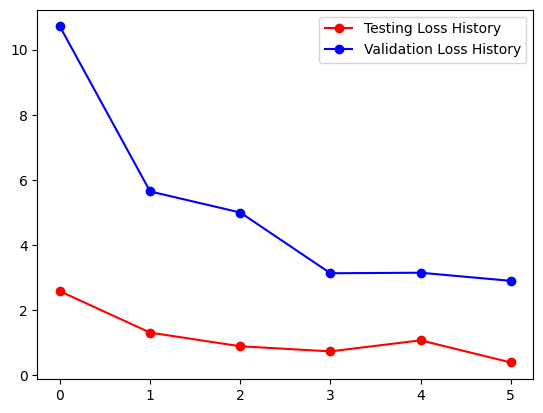

In [ ]:
plt.plot(loss_history,'o-r', label='Testing Loss History')
plt.plot(val_loss_history,'o-b', label='Validation Loss History')
plt.legend()

Метрики обучения на тренировочной и валидационной выборке

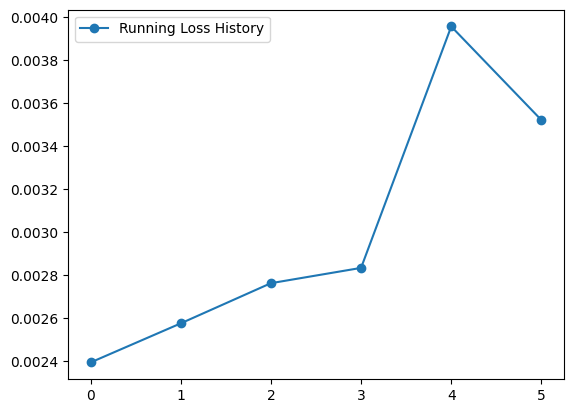

In [ ]:
plt.plot(metric_history,'o-', label='Running Loss History')
plt.legend()

Нахождение максимальной метрики

In [ ]:
max_metric=max(metric_history)
id_max_metric=metric_history.index(max_metric)
print(max_metric)
print(id_max_metric)

0.0039568427
4


Сохранение лучших параметров модели в новую

In [ ]:
model_max_metric = torch.load("/content/drive/MyDrive/new_model4.pth")
optimizer=torch.optim.Adam(model_max_metric.parameters(),lr=0.00001)

Тестирование сохраненной модели

In [ ]:
test_loss_history=[]
test_metric_history=[]
test_correct_history=[]

loss = 0.0
correct = 0.0
metric = 0.0
for num_file in tqdm(test_ids):
    loss = 0.0
    correct = 0.0
    metric = 0.0


    itk_img = itk.ReadImage(f'{path}/{num_file}_image.nii.gz')
    img = itk.GetArrayFromImage(itk_img)
    itk_img = itk.ReadImage(f'{path}/{num_file}_label.nii.gz')
    msk = itk.GetArrayFromImage(itk_img)

    temp=0
    for num_image in range(0, img.shape[0], 1):
        image = np.array(img[num_image].copy())

        image_tensor = transform(image).float()
        image_tensor = image_tensor.to(device)


        mask = np.array(msk[num_image], dtype=np.float32)
        mask[mask == 2] = 1
        mask[mask == 3] = 1
        mask_tensor = transform(mask).float()
        mask_tensor=mask_tensor.to(device)


        outputs = model_max_metric(image_tensor.unsqueeze(0))
        loss1 = criteron(outputs, mask_tensor.unsqueeze(0))
        metric1=iou_pytorch(outputs,mask_tensor)
        #metric1=metric_IoU(outputs.unsqueeze(0), mask_tensor.unsqueeze(0))
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        loss1=loss1.to(device)
        loss += loss1.item()
        metric += metric1.item()
        correct += torch.sum(preds == mask_tensor.data)
        #print(temp)
        #temp+=1
    else:
        test_epoch_loss=loss/len(test_ids)
        test_epoch_acc=correct.float()/len(test_ids)
        test_epoch_metric=metric/len(test_ids)
        test_loss_history.append(test_epoch_loss)
        test_metric_history.append(test_epoch_metric)
        test_correct_history.append(test_epoch_acc)
        print('training_loss:{:.4f},{:.4f}'.format(test_epoch_loss,test_epoch_acc.item()))
        print('validation_loss:{:.4f},{:.4f}'.format(test_epoch_loss,test_epoch_acc.item()))


 17%|█▋        | 1/6 [02:15<11:19, 135.92s/it]

training_loss:0.1801,24390380.0000
validation_loss:0.1801,24390380.0000


 33%|███▎      | 2/6 [03:30<06:39, 99.91s/it] 

training_loss:0.2558,13350974.0000
validation_loss:0.2558,13350974.0000


 50%|█████     | 3/6 [04:45<04:25, 88.63s/it]

training_loss:0.1411,13861207.0000
validation_loss:0.1411,13861207.0000


 67%|██████▋   | 4/6 [06:07<02:51, 85.95s/it]

training_loss:0.1098,14958963.0000
validation_loss:0.1098,14958963.0000


 83%|████████▎ | 5/6 [07:21<01:21, 81.44s/it]

training_loss:0.1459,13223644.0000
validation_loss:0.1459,13223644.0000


100%|██████████| 6/6 [08:50<00:00, 88.44s/it]

training_loss:0.2712,16464706.0000
validation_loss:0.2712,16464706.0000


Погрешнось обучения тестовой выборки

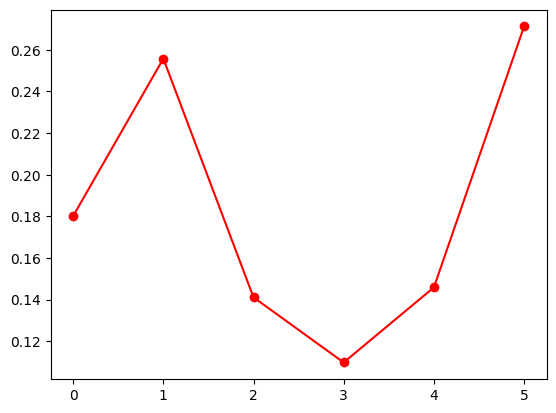

In [ ]:
plt.plot(test_loss_history, 'o-r', label='Running Loss History')

Метрики обучения тестовой выборки

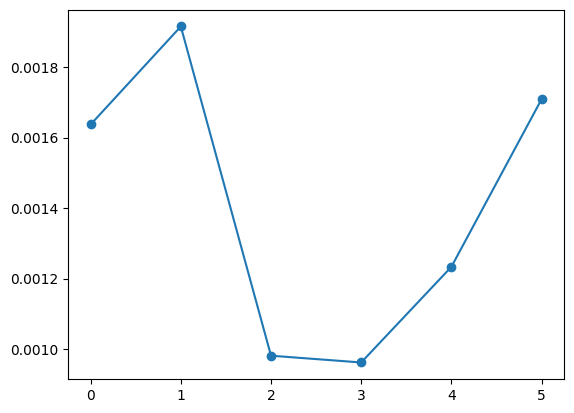

In [ ]:
plt.plot(test_metric_history,'o-', label='Running Loss History')



---



---



---



---



Сохранение и загрузка модели

In [ ]:
torch.save(model, 'model4.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/new_model4.pth')

Сохранение и загрузка параметров модели

In [ ]:
torch.save(model.state_dict(), 'model_parameters4.pth')

In [ ]:
model.load_state_dict(torch.load('new_model_parameters4.pth'))

Сохранить  и загрузить состояние оптимизатора


In [ ]:
torch.save(optimizer.state_dict(), 'optimizer_state4.pth')

In [ ]:
optimizer.load_state_dict(torch.load('optimizer_state.pth'))